In [18]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

#from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
#import mitequinox.sigp as sp



In [16]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51610 instead
  http_address["port"], self.http_server.port


In [55]:
path = '/Users/zcaspar/codes/mit4320/'
dsL = xr.open_dataset(path+'binned_Lcov.nc')
dsE = xr.open_dataset(path+'binned_Ecov.nc')

In [56]:
dsL = dsL.isel(lags=slice(0,None,3)).sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))

In [21]:
dsE = dsE.isel(lat_bins=slice(0,None,2),lon_bins=slice(0,None,2))

In [57]:
lat_bins2 = np.arange(-60,60,2.)
lon_bins2 = np.arange(-180,180,2.)


In [58]:
dsE.lat_bins.values

array([-59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5,
       -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5,
       -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5,
       -32.5, -31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5, -24.5,
       -23.5, -22.5, -21.5, -20.5, -19.5, -18.5, -17.5, -16.5, -15.5,
       -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,
        -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,
         3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,
        12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,  20.5,
        21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,
        39.5,  40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,
        48.5,  49.5,  50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,
        57.5,  58.5])

In [59]:
np.histogram2d(dsE.lat_bins.values,dsE.lon_bins.values,bins=[lat_bins2,lon_bins2])

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

In [50]:
dsE.groupby_bins(['lon_bins'],lon_bins2).mean()

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:        (lags: 321, lat_bins: 60, lon_bins_bins: 179)
Coordinates:
  * lon_bins_bins  (lon_bins_bins) object (-180.0, -178.0] ... (176.0, 178.0]
  * lat_bins       (lat_bins) float64 -59.5 -57.5 -55.5 -53.5 ... 54.5 56.5 58.5
  * lags           (lags) float64 0.0 0.125 0.25 0.375 ... 39.75 39.88 40.0
Data variables:
    Crr            (lon_bins_bins, lags, lat_bins) float64 0.0009572 ... -0.004266

In [47]:
N = histogram(dsE.lon_bins.rename('lon'), dsE.lat_bins.rename('lat'), 
              bins=[lon_bins2,lat_bins2], 
              dim=['i', 'j', 'face']
             )

ValueError: 'i' not found in array dimensions ('lon_bins', 'lat_bins')

Text(0.5, 1.0, 'Lagrangian amplitude')

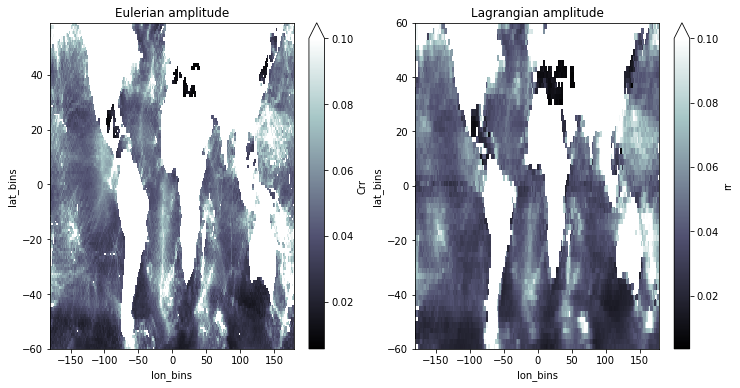

In [60]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
np.sqrt(dsE.isel(lags=0).Crr).plot(ax=axs[0],vmax=0.1,cmap='bone',y='lat_bins')
axs[0].set_title('Eulerian amplitude')
np.sqrt(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.1,cmap='bone',y='lat_bins')
axs[1].set_title('Lagrangian amplitude')

Text(0.5, 1.0, 'Lagrangian real-real covariance')

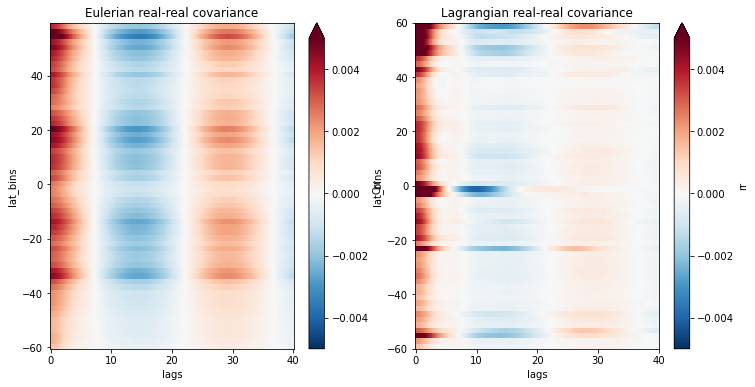

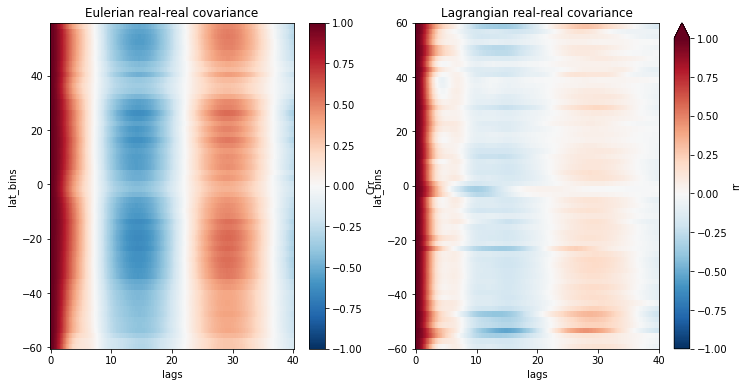

In [24]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').Crr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')


fig,axs = plt.subplots(1,2,figsize=(12,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).Crr.plot(y='lat_bins',ax=axs[0],vmax=1)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')



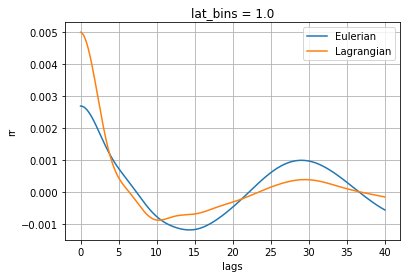

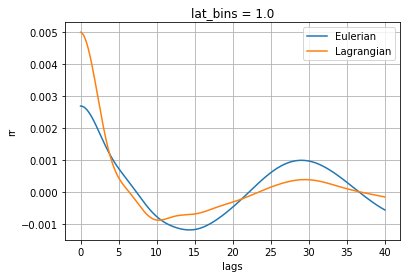

In [39]:
dsE.mean('lon_bins').sel(lat_bins=.5).Crr.plot(label='Eulerian')
dsL.mean('lon_bins').sel(lat_bins=1.).rr.plot(label='Lagrangian')
plt.grid();plt.legend()

plt.figure()
dsE.mean('lon_bins').sel(lat_bins=.5).Crr.plot(label='Eulerian')
dsL.mean('lon_bins').sel(lat_bins=1.).rr.plot(label='Lagrangian')
plt.grid();plt.legend()
#dsL.mean('lon_bins').sel(lat_bins=-1.).rr.plot()

(-0.7, 1.1)

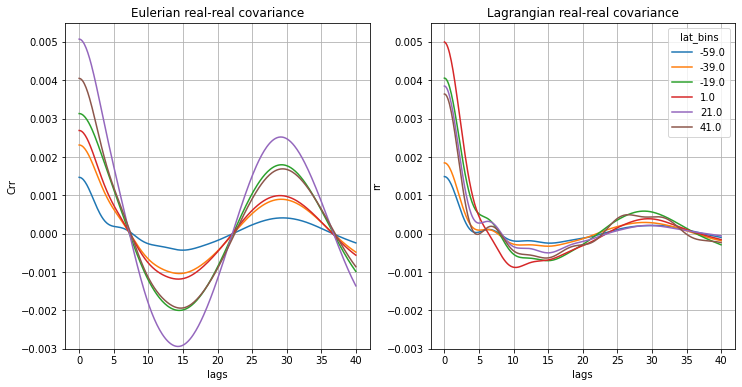

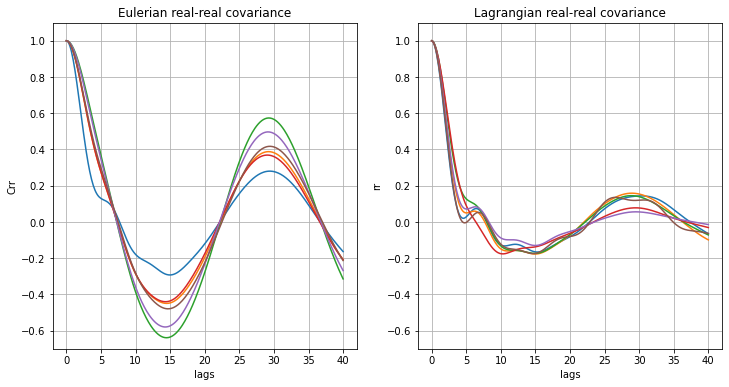

In [45]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').Crr.isel(lat_bins=slice(0,None,10)).plot(hue='lat_bins',ax=axs[0],add_legend=False)
dsL.mean('lon_bins').rr.isel(lat_bins=slice(0,None,10)).plot(hue='lat_bins',ax=axs[1],add_legend=True)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid()
axs[0].set_ylim(-0.003,0.0055);axs[1].set_ylim(-0.003,0.0055)

fig,axs = plt.subplots(1,2,figsize=(12,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).Crr.isel(lat_bins=slice(0,None,10)
                                                                 ).plot(hue='lat_bins',ax=axs[0],add_legend=False)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.isel(lat_bins=slice(0,None,10)
                                                                ).plot(hue='lat_bins',ax=axs[1],add_legend=False)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid();axs[0].set_ylim(-0.7,1.1);axs[1].set_ylim(-0.7,1.1)

In [17]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
